In [2]:
import pandas as pd
import numpy as np
from numpy import sin, sign, cos
import pickle
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
pd.set_option('display.max_columns', None)

# Constants
Ci0 = 0.05  # Rolling inertia coefficient
Cd = 0.29  # Air drag coefficient
rho = 1.225  # Density of air
g = 9.81  # Gravitational acceleration
Vwind = 0  # Velocity of wind
A = 2.33  # Cross-sectional area of car
mcar = 1966  # Mass of car
mp = 80  # Mass of passengers
theta = 0  # Road slope


def get_traction_power(V, ux):  # Velocity, x-axis acceleration
    Crr = 0.01 * (1 + V) / 100  # Rolling resistance coefficient

    Fhc = (mcar + mp) * g * sin(theta)  # Hill climbing force
    Faero = sign(V + Vwind) * 1/2 * rho * A * Cd * (V + Vwind)**2  # Aerodynamic drag
    Fi = Ci0 * (mcar + mp) * ux  # Inertial force
    Frr = sign(V) * (mcar + mp) * g * cos(theta) * Crr  # Rolling resistance force of the wheels

    Ft = Fhc + Faero + Fi + Frr

    Pt = Ft * V
    return Pt


In [5]:
data_dir = "../data/processed"

def load_trip(routes, trips):
    dfs = []
    for route in routes:
        for trip in trips:
            df = []
            for file_path in glob.glob(os.path.join(data_dir, route, f"trip_{trip}_*.pickle")):
                with open(file_path, "rb") as f:
                    df_ = pickle.load(f)
                _, trip, i = os.path.splitext(os.path.basename(file_path))[0].split("_")
                df_ = df_.assign(trip=trip)\
                        .assign(route=route)
                df_ = df_.fillna(np.nan).groupby('segment_id').first().reset_index()
                df.append(df_)
            df = pd.concat(df)
            df = df.fillna(np.nan).groupby('segment_id').first().reset_index()
            df["obd.trac_cons.value"] = df["obd.trac_cons.value"] - 160
            dfs.append(df)
    return pd.concat(dfs)

In [9]:
df = load_trip(routes=["M3_VH"], trips=[7995])
df_test = load_trip(routes=["M3_VH"], trips=[7448])

array([[<AxesSubplot:title={'center':'obd.trac_cons.value'}>,
        <AxesSubplot:title={'center':'obd.spd.value'}>],
       [<AxesSubplot:title={'center':'acc.xyz.z'}>,
        <AxesSubplot:title={'center':'acc.xyz.x'}>]], dtype=object)

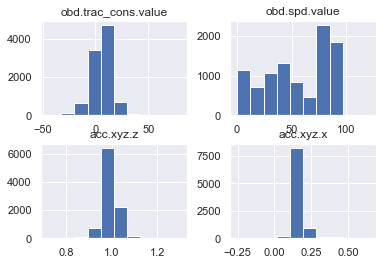

In [10]:
df[["obd.trac_cons.value", "obd.spd.value", "acc.xyz.z", "acc.xyz.x"]].hist()

In [23]:
df = df.assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)\
       .assign(error=lambda x: (x["kW_pred"] - x["obd.trac_cons.value"]))\
       .assign(abserror=lambda x: np.abs(x["error"]))

df_test = df_test.assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)\
       .assign(error=lambda x: (x["kW_pred"] - x["obd.trac_cons.value"]))\
       .assign(abserror=lambda x: np.abs(x["error"]))

[Text(0.5, 1.0, 'Unsmoothed physical model prediction on test set')]

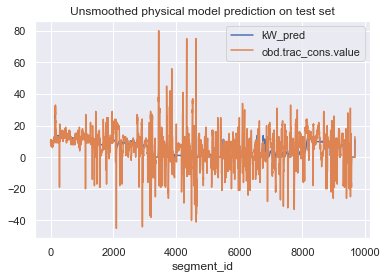

In [46]:
df.plot(x="segment_id", y=["kW_pred", "obd.trac_cons.value"])\
  .set(title="Unsmoothed physical model prediction on test set")

[Text(0.5, 1.0, 'Physical model prediction on training set')]

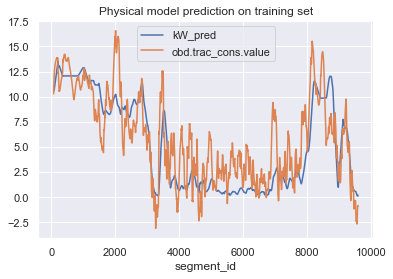

In [45]:
df.drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)\
    .rolling(150).mean()\
    .plot(x="segment_id", y=["kW_pred", "obd.trac_cons.value"])\
    .set(title="Physical model prediction on training set")

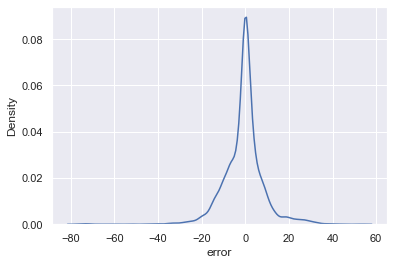

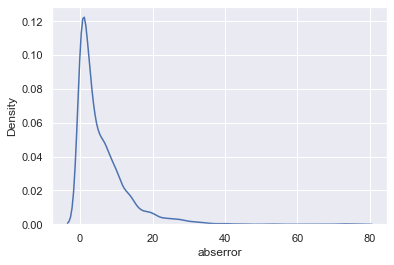

In [26]:
sns.kdeplot(df.error)
plt.show()

sns.kdeplot(df.abserror)
plt.show()

In [27]:
features = ["acc.xyz.x", "acc.xyz.y", "acc.xyz.z",
            "obd.strg_pos.value", "obd.strg_ang.value", "obd.strg_acc.value", 
            "obd.acc_yaw.value", "obd.spd.value", "obd.odo.value", 
            "obd.ww_f_stat.value", "obd.sb_rem_fl.value", "traffic_lights",
            "road_signs", "speed_limit", "ped_walks", "speed_bumps", "bike_lane", "start_hour"]

target = "error"

In [28]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(df[features], df[target])

LGBMRegressor()

In [37]:
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb

# def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
#                        model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
#                        do_probabilities = False):
#     gs = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid, 
#         cv=cv, 
#         n_jobs=-1, 
#         scoring=scoring_fit,
#         verbose=2
#     )
#     fitted_model = gs.fit(X_train_data, y_train_data)
    
#     if do_probabilities:
#       pred = fitted_model.predict_proba(X_test_data)
#     else:
#       pred = fitted_model.predict(X_test_data)
    
#     return fitted_model, pred

# model = lgb.LGBMRegressor()
# param_grid = {
#     'n_estimators': [400, 700, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15,20,25],
#     'num_leaves': [50, 100, 200],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
#     'min_split_gain': [0.3, 0.4],
#     'subsample': [0.7, 0.8, 0.9],
#     'subsample_freq': [20]
# }

# model, pred = algorithm_pipeline(df[features].to_numpy(), df_test[features].to_numpy(), df[target].to_numpy(), df_test[target].to_numpy(), model, 
#                                  param_grid, cv=5)

# print(model.best_score_)
# print(model.best_params_)

[Text(0.5, 1.0, 'Compound model prediction on training set')]

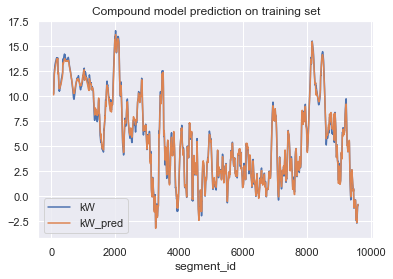

In [44]:
df.assign(error_pred=model.predict(df[features]))\
  .assign(kW_pred=lambda x: x.kW_pred - x.error_pred)\
    .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)\
    .rolling(150).mean()\
  .plot(x="segment_id", y=["kW", "kW_pred"])\
  .set(title="Compound model prediction on training set")

[Text(0.5, 1.0, 'Physical model prediction on test set')]

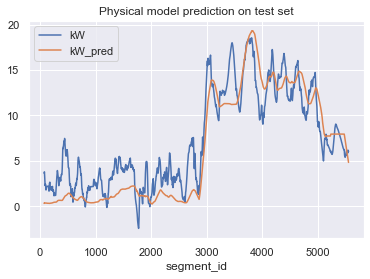

In [42]:
df_test\
  .assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)\
  .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)\
  .rolling(150).mean()\
  .plot(x="segment_id", y=["kW", "kW_pred"])\
  .set(title="Physical model prediction on test set")

[Text(0.5, 1.0, 'Compound model prediction on test set')]

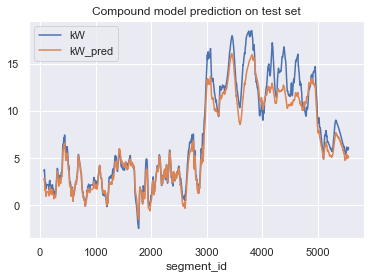

In [43]:
df_test.assign(error_pred=model.predict(df_test[features]))\
  .assign(kW_pred=lambda x: get_traction_power(x["obd.spd.value"], x["acc.xyz.x"]) / 25000)\
  .assign(kW_pred=lambda x: x.kW_pred - x.error_pred)\
  .drop(['Date', 'T', 'TS_or_Distance', 'Time', 'route', 'street_name_end', 'street_name_start'], axis=1)\
  .rolling(150).mean()\
  .plot(x="segment_id", y=["kW", "kW_pred"])\
  .set(title="Compound model prediction on test set")

Still trying to understand why `acc.xyz.y` has such a huge impact.
However, the impact of `obd.spd.value` is intuitive.
The faster you go, the bigger the effect of road friction, and road friction is one of the two effects (along with the wind) which are not taken into account in the physical model.

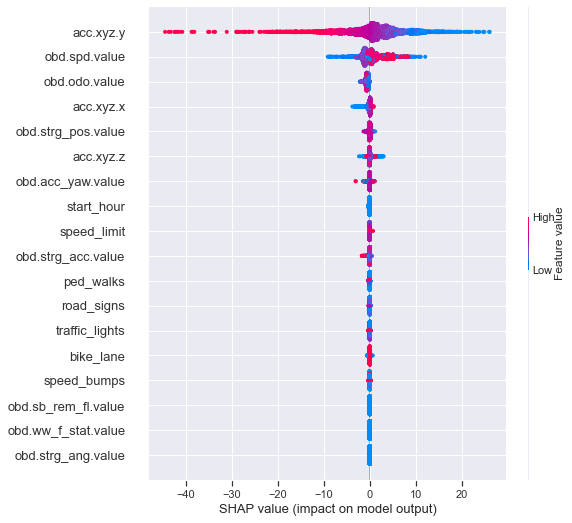

In [41]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test[features])

shap.summary_plot(shap_values, df_test[features])